In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch
import gc
import os
import imageio
import yaml
from torch.optim import Adam
from datetime import datetime
from PIL import Image
import requests
from io import BytesIO

In [ ]:
def generate_2D_gaussian_splatting(kernel_size, scale, rotation, coords, colours, image_size=(256, 256, 3), device="cpu"):
    batch_size = colours.shape[0]

    # Ensure scale and rotation have the correct shape
    scale = scale.view(batch_size, 2)
    rotation = rotation.view(batch_size)

    # Compute the components of the covariance matrix
    cos_rot = torch.cos(rotation)
    sin_rot = torch.sin(rotation)

    R = torch.stack([
        torch.stack([cos_rot, -sin_rot], dim=-1),
        torch.stack([sin_rot, cos_rot], dim=-1)
    ], dim=-2)

    S = torch.diag_embed(scale)

    # Compute covariance matrix: RSS^TR^T
    # covariance = R @ S @ S.transpose(-1, -2) @ R.transpose(-1, -2)
    # since in 2D , SS^T = SS and since transpose potentially could cause memory access issue
    covariance = R @ S @ S @ R.transpose(-1, -2)

    # Compute inverse covariance
    inv_covariance = torch.inverse(covariance)

    # Create the kernel
    x = torch.linspace(-5, 5, kernel_size, device=device)
    y = torch.linspace(-5, 5, kernel_size, device=device)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    xy = torch.stack([xx, yy], dim=-1).unsqueeze(0).expand(batch_size, -1, -1, -1)

    z = torch.einsum('bxyi,bij,bxyj->bxy', xy, -0.5 * inv_covariance, xy)
    kernel = torch.exp(z) / (2 * torch.tensor(np.pi, device=device) * torch.sqrt(torch.det(covariance))).view(batch_size, 1, 1)

    # Normalize the kernel
    kernel_max = kernel.amax(dim=(-2, -1), keepdim=True)
    kernel_normalized = kernel / kernel_max

    # Reshape the kernel for RGB channels
    kernel_rgb = kernel_normalized.unsqueeze(1).expand(-1, 3, -1, -1)

    # Add padding to match image size
    pad_h = image_size[0] - kernel_size
    pad_w = image_size[1] - kernel_size

    if pad_h < 0 or pad_w < 0:
        raise ValueError("Kernel size should be smaller or equal to the image size.")

    padding = (pad_w // 2, pad_w // 2 + pad_w % 2, pad_h // 2, pad_h // 2 + pad_h % 2)
    kernel_rgb_padded = F.pad(kernel_rgb, padding, "constant", 0)

    # Translate the kernel
    b, c, h, w = kernel_rgb_padded.shape
    theta = torch.zeros(b, 2, 3, dtype=torch.float32, device=device)
    theta[:, 0, 0] = 1.0
    theta[:, 1, 1] = 1.0
    theta[:, :, 2] = coords

    grid = F.affine_grid(theta, size=(b, c, h, w), align_corners=True)
    kernel_rgb_padded_translated = F.grid_sample(kernel_rgb_padded, grid, align_corners=True)

    # Apply colors and sum the layers
    rgb_values_reshaped = colours.unsqueeze(-1).unsqueeze(-1)
    final_image_layers = rgb_values_reshaped * kernel_rgb_padded_translated
    final_image = final_image_layers.sum(dim=0)
    final_image = torch.clamp(final_image, 0, 1)
    final_image = final_image.permute(1, 2, 0)

    return final_image

In [ ]:
def create_window(window_size, channel):
    def gaussian(window_size, sigma):
        gauss = torch.exp(torch.tensor([-(x - window_size//2)**2/float(2*sigma**2) for x in range(window_size)]))
        return gauss/gauss.sum()

    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.autograd.Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())

    return window



def ssim(img1, img2, window_size=11, size_average=True):

    (_, _, channel) = img1.size()

    img1 = img1.unsqueeze(0).permute(0, 3, 1, 2)
    img2 = img2.unsqueeze(0).permute(0, 3, 1, 2)


    # Parameters for SSIM
    C1 = 0.01**2
    C2 = 0.03**2

    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    SSIM_numerator = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))
    SSIM_denominator = ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    SSIM = SSIM_numerator / SSIM_denominator

    return torch.clamp((1 - SSIM) / 2, 0, 1)

def d_ssim_loss(img1, img2, window_size=11, size_average=True):
    return ssim(img1, img2, window_size, size_average).mean()

# Combined Loss
def combined_loss(pred, target, lambda_param=0.5):
    l1loss = nn.L1Loss()
    return (1 - lambda_param) * l1loss(pred, target) + lambda_param * d_ssim_loss(pred, target)

torch.Size([2400, 4094])
torch.Size([700, 700])


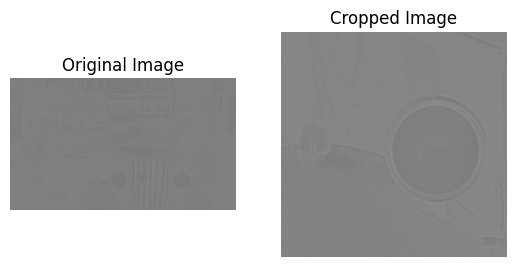

In [ ]:
# URL of the sample hologram image
github_url = "https://raw.githubusercontent.com/kaanaksit/odak/master/test/data/sample_hologram.png"

# Fetch the image from GitHub
response = requests.get(github_url)
response.raise_for_status()  # Raise an error for failed requests

# Open the image
image = Image.open(BytesIO(response.content)).convert('L')  # Convert to grayscale

# Convert the image to a numpy array
hologram_array = np.array(image)

# Convert the hologram array to a PyTorch tensor
hologram_tensor = torch.tensor(hologram_array / 255.0, dtype=torch.float32)

# Crop the hologram tensor
left = 1500 # x-coordinate of the left edge
top = 1500  # y-coordinate of the top edge
right = 2200  # x-coordinate of the right edge
bottom = 2200  # y-coordinate of the bottom edge
cropped_hologram_tensor = hologram_tensor[top:bottom, left:right]

# Display the original and cropped images
plt.subplot(1, 2, 1)
plt.imshow(hologram_tensor.numpy(), cmap='gray')
plt.axis('off')  # Hide axes
print(hologram_tensor.shape)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cropped_hologram_tensor.numpy(), cmap='gray')
plt.axis('off')  # Hide axes
print(cropped_hologram_tensor.shape)
plt.title('Cropped Image')
plt.show()

# Save the cropped image
cropped_image = Image.fromarray((cropped_hologram_tensor.numpy() * 255).astype(np.uint8))
cropped_image.save("Image-01.png")

In [ ]:
url2 = 'https://raw.githubusercontent.com/OutofAi/2D-Gaussian-Splatting/main/config.yml'
filename2 = url2.split('/')[-1]
response2 = requests.get(url2)
with open(filename2, 'wb') as f:
    f.write(response2.content)

In [ ]:
# Modify the image_size
with open(filename2, 'r') as f:
    lines = f.readlines()

with open(filename2, 'w') as f:
    for line in lines:
        if line.strip().startswith('image_size:'):
            f.write("image_size: [700, 700]\n")
        else:
            f.write(line)

In [ ]:
with open(filename2, 'w') as f:
    for line in lines:
        if line.strip().startswith('num_epochs:'):
            f.write("num_epochs: 20001\n")
        else:
            f.write(line)

## Load Config ##

In [ ]:
# Read the config.yml file
with open('config.yml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Extract values from the loaded config
KERNEL_SIZE = config["KERNEL_SIZE"]
image_size = tuple(config["image_size"])
primary_samples = config["primary_samples"]
backup_samples = config["backup_samples"]
num_epochs = config["num_epochs"]
densification_interval = config["densification_interval"]
learning_rate = config["learning_rate"]
image_file_name = config["image_file_name"]
display_interval = config["display_interval"]
grad_threshold = config["gradient_threshold"]
gauss_threshold = config["gaussian_threshold"]
display_loss = config["display_loss"]


## Prepate the points ##

In [ ]:
def give_required_data(input_coords, image_size):

  # normalising pixel coordinates [-1,1]
  coords = torch.tensor(input_coords / [image_size[0],image_size[1]], device=device).float()
  center_coords_normalized = torch.tensor([0.5, 0.5], device=device).float()
  coords = (center_coords_normalized - coords) * 2.0

  # Fetching the colour of the pixels in each coordinates
  colour_values = [image_array[coord[1], coord[0]] for coord in input_coords]
  colour_values_np = np.array(colour_values)
  colour_values_tensor =  torch.tensor(colour_values_np, device=device).float()

  return colour_values_tensor, coords

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_samples = primary_samples + backup_samples

PADDING = KERNEL_SIZE // 2
image_path = image_file_name
original_image = Image.open(image_path)
original_image = original_image.resize((image_size[0],image_size[0]))
original_image = original_image.convert('RGB')
original_array = np.array(original_image)
original_array = original_array / 255.0
width, height, _ = original_array.shape

image_array = original_array
target_tensor = torch.tensor(image_array, dtype=torch.float32, device=device)
coords = np.random.randint(0, [width, height], size=(num_samples, 2))
random_pixel_means = torch.tensor(coords, device=device)
pixels = [image_array[coord[0], coord[1]] for coord in coords]
pixels_np = np.array(pixels)
random_pixels =  torch.tensor(pixels_np, device=device)

colour_values, pixel_coords = give_required_data(coords, image_size)

colour_values = torch.logit(colour_values)
pixel_coords = torch.atanh(pixel_coords)

scale_values = torch.logit(torch.rand(num_samples, 2, device=device))
rotation_values = torch.atanh(2 * torch.rand(num_samples, 1, device=device) - 1)
alpha_values = torch.logit(torch.rand(num_samples, 1, device=device))
W_values = torch.cat([scale_values, rotation_values, alpha_values, colour_values, pixel_coords], dim=1)


In [ ]:
starting_size = primary_samples
left_over_size = backup_samples
persistent_mask = torch.cat([torch.ones(starting_size, dtype=bool),torch.zeros(left_over_size, dtype=bool)], dim=0)
current_marker = starting_size

In [ ]:
# Get current date and time as string
now = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

# Create a directory with the current date and time as its name
directory = f"{now}"
os.makedirs(directory, exist_ok=True)

In [ ]:
W = nn.Parameter(W_values)
optimizer = Adam([W], lr=learning_rate)
loss_history = []

## Training Loop ##

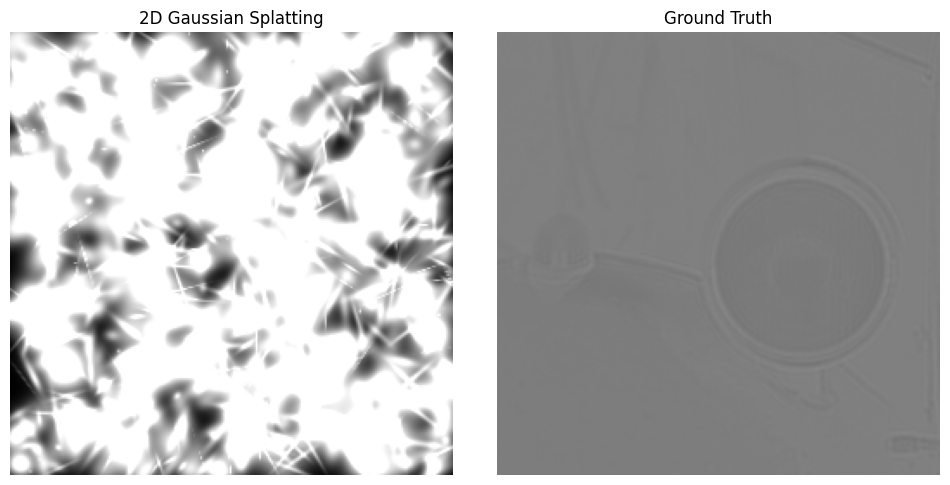

Epoch 1/20001, Loss: 0.36874300241470337, on 1000 points


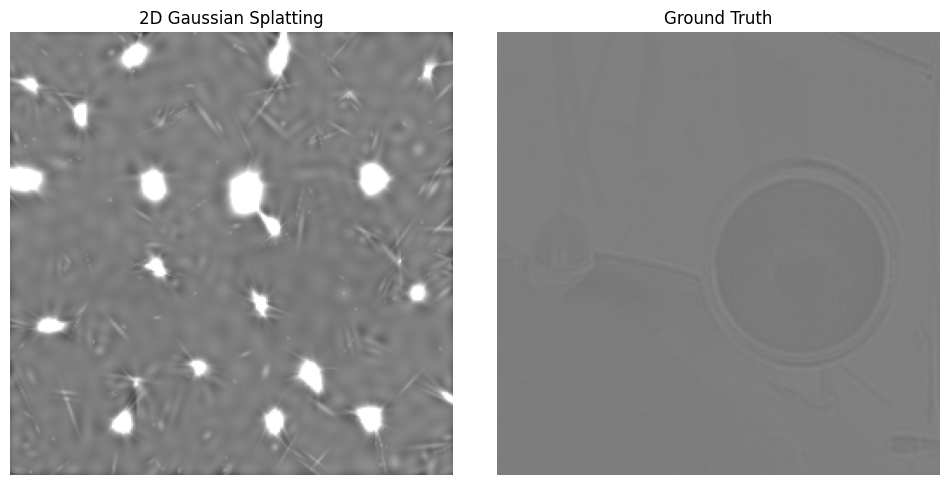

Epoch 101/20001, Loss: 0.06065845489501953, on 1000 points


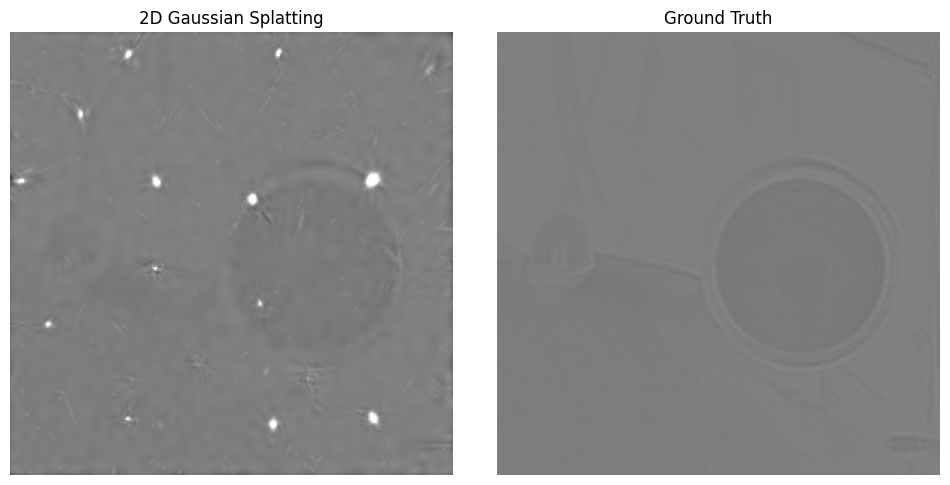

Epoch 201/20001, Loss: 0.014667310751974583, on 1000 points
Number of splitted points: 210
Number of cloned points: 57


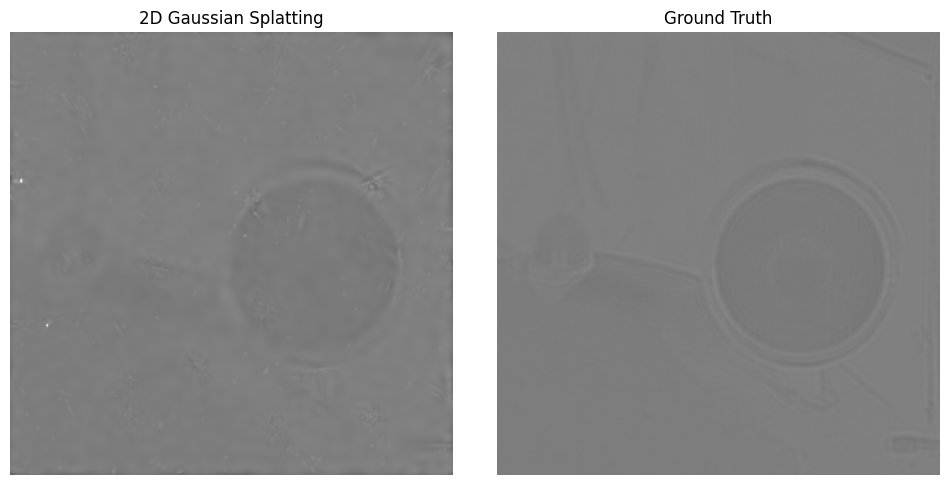

Epoch 301/20001, Loss: 0.0073416209779679775, on 1000 points
number of pruned points: 55


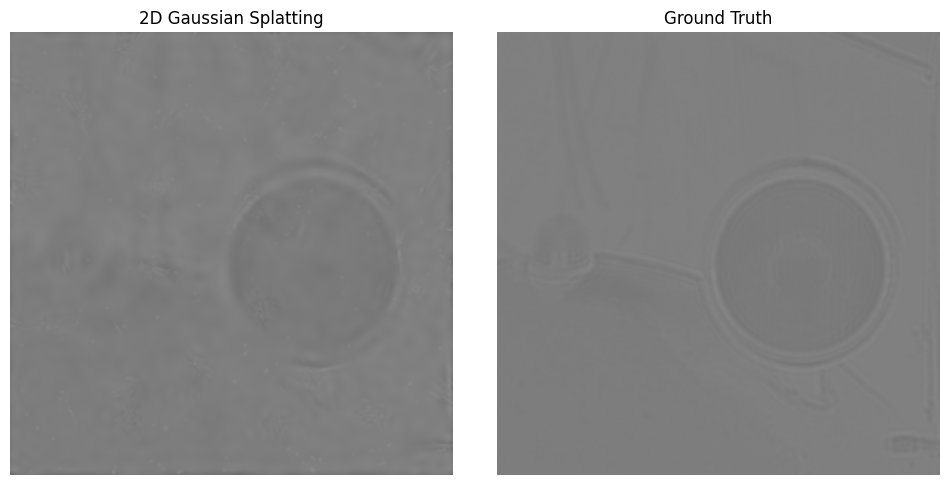

Epoch 401/20001, Loss: 0.006212730426341295, on 1252 points


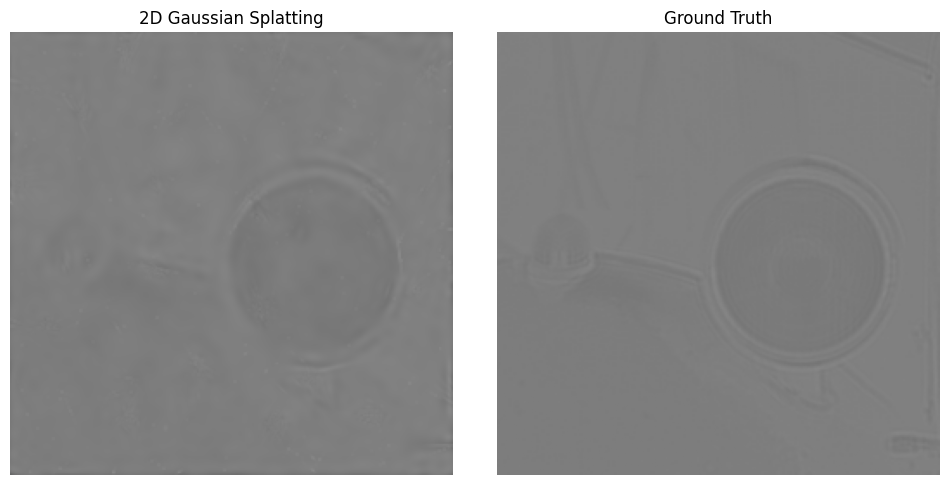

Epoch 501/20001, Loss: 0.005380399990826845, on 1252 points
Number of splitted points: 322
Number of cloned points: 77


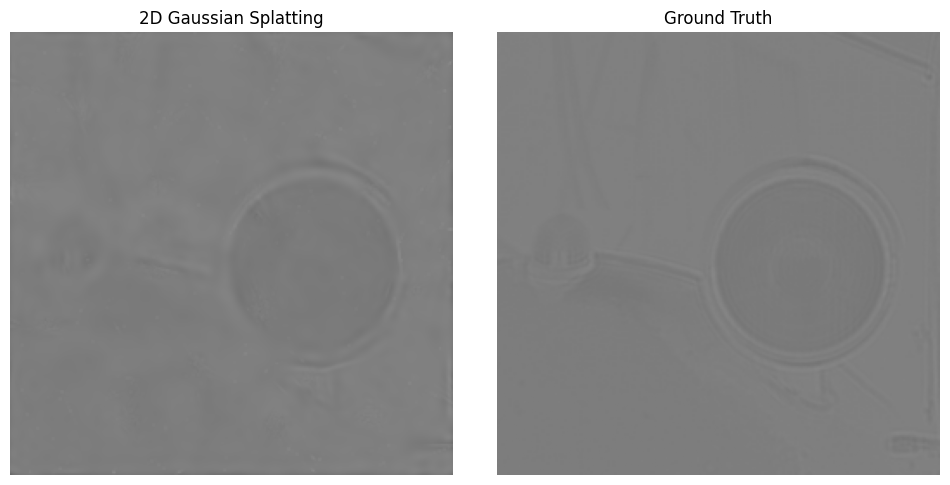

Epoch 601/20001, Loss: 0.0050522638484835625, on 1252 points


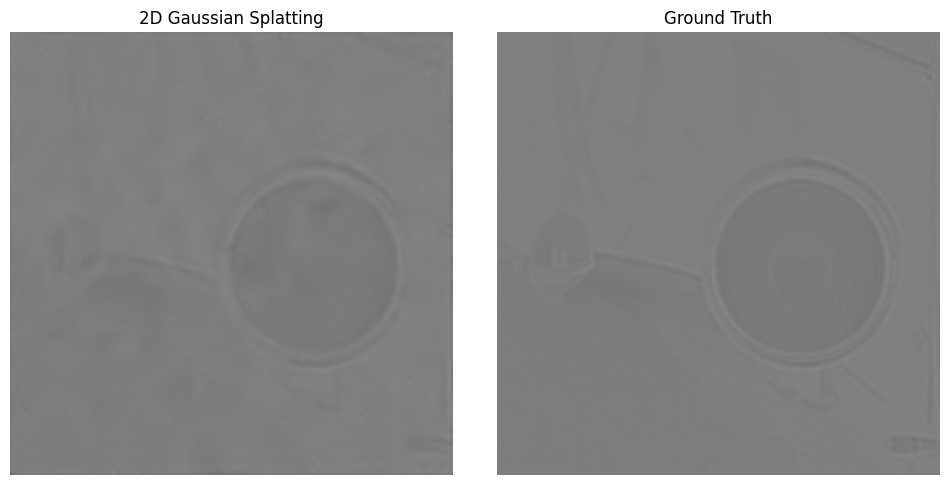

Epoch 701/20001, Loss: 0.004910990595817566, on 1651 points


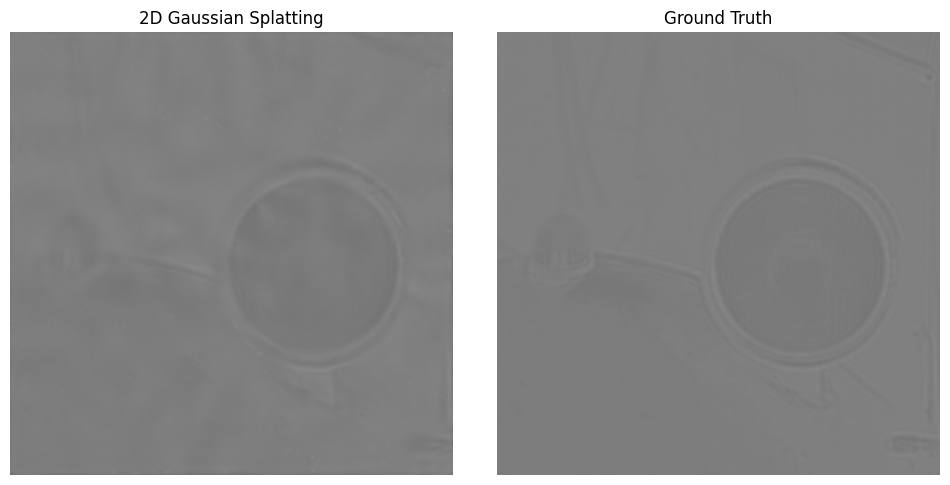

Epoch 801/20001, Loss: 0.005188734270632267, on 1651 points
Number of splitted points: 362
Number of cloned points: 139


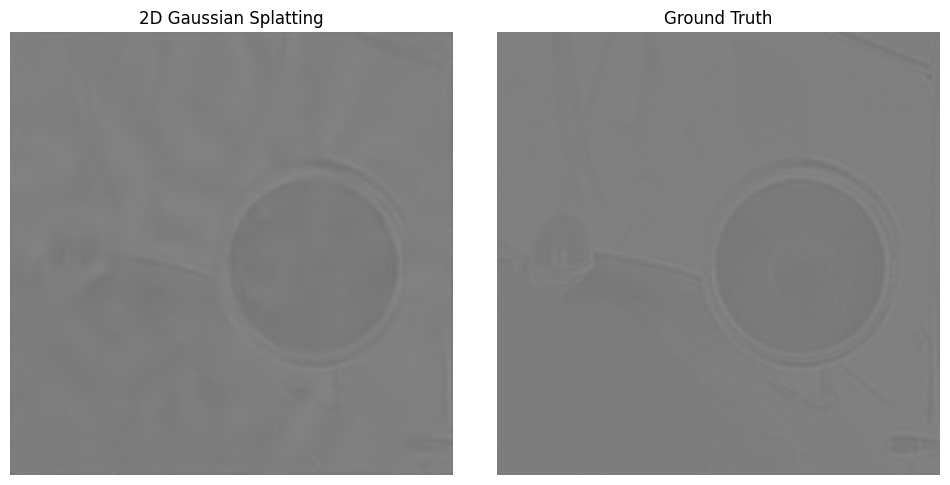

Epoch 901/20001, Loss: 0.004837614018470049, on 1651 points


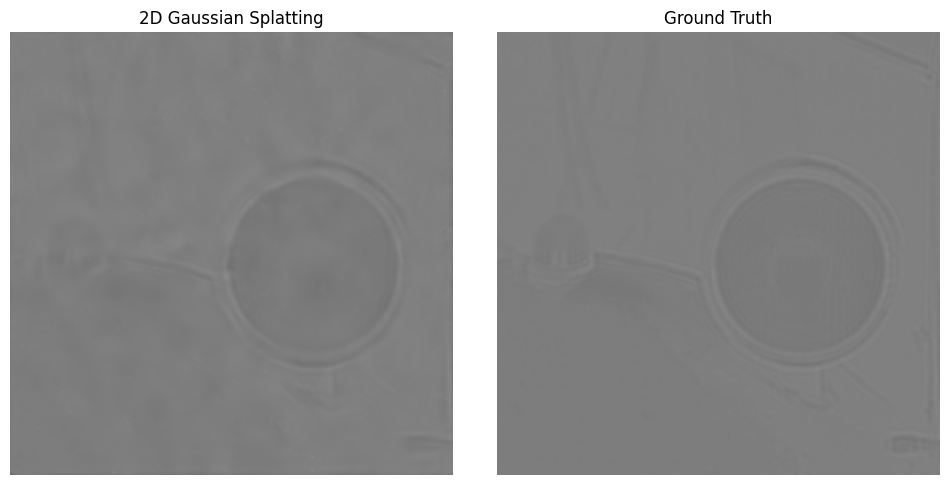

Epoch 1001/20001, Loss: 0.004681833554059267, on 2152 points


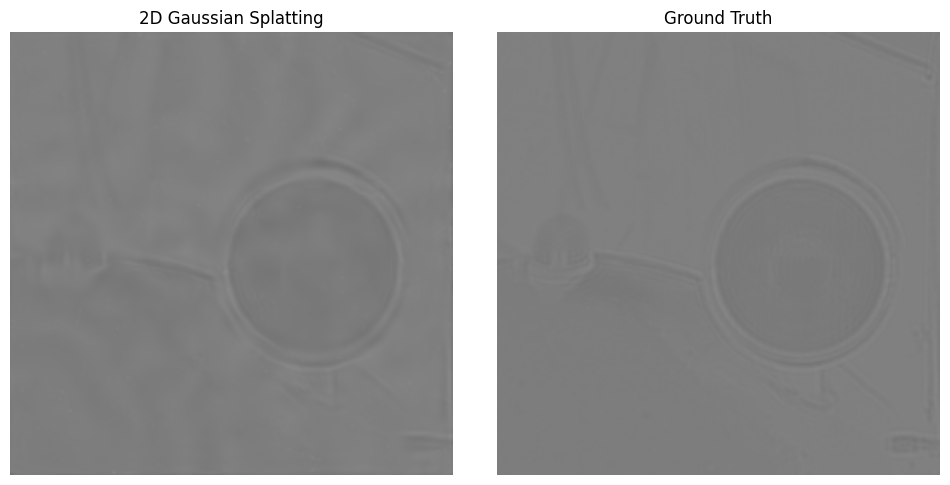

Epoch 1101/20001, Loss: 0.004651888273656368, on 2152 points
Number of splitted points: 361
Number of cloned points: 189


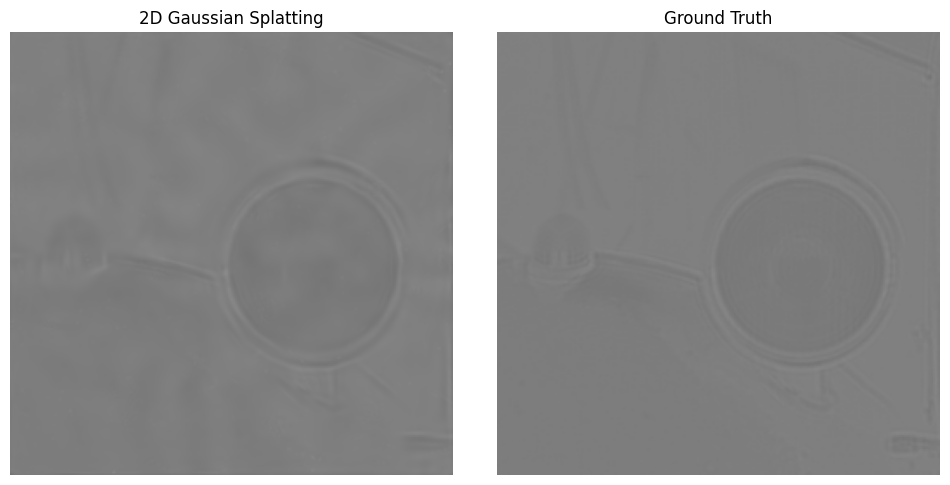

Epoch 1201/20001, Loss: 0.004341122694313526, on 2152 points


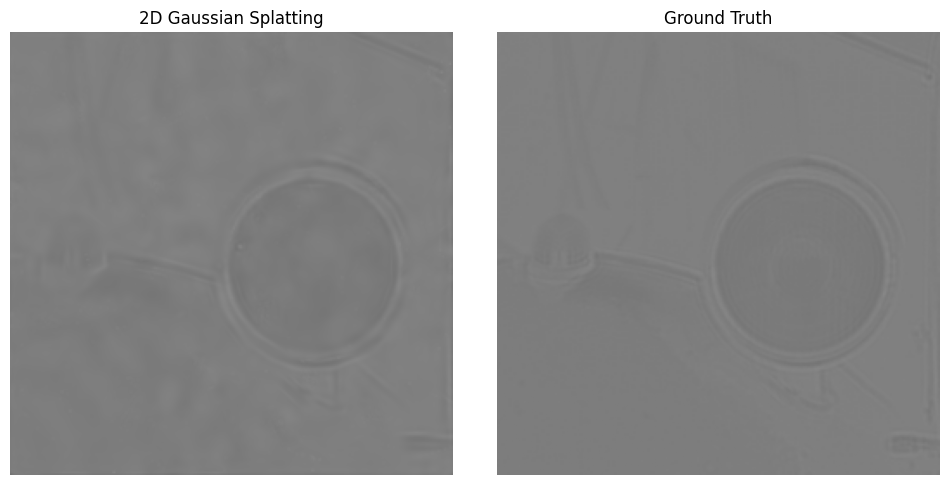

Epoch 1301/20001, Loss: 0.004290017299354076, on 2702 points


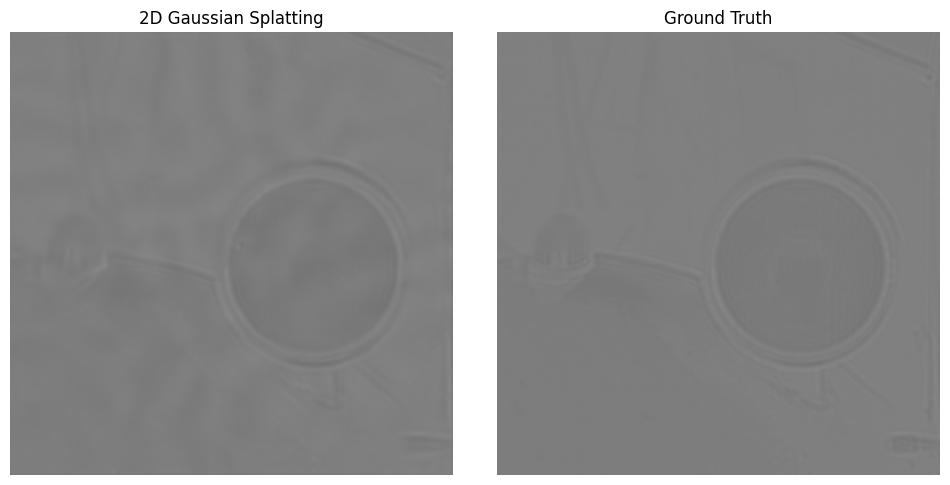

Epoch 1401/20001, Loss: 0.004468943923711777, on 2702 points
Number of splitted points: 341
Number of cloned points: 262


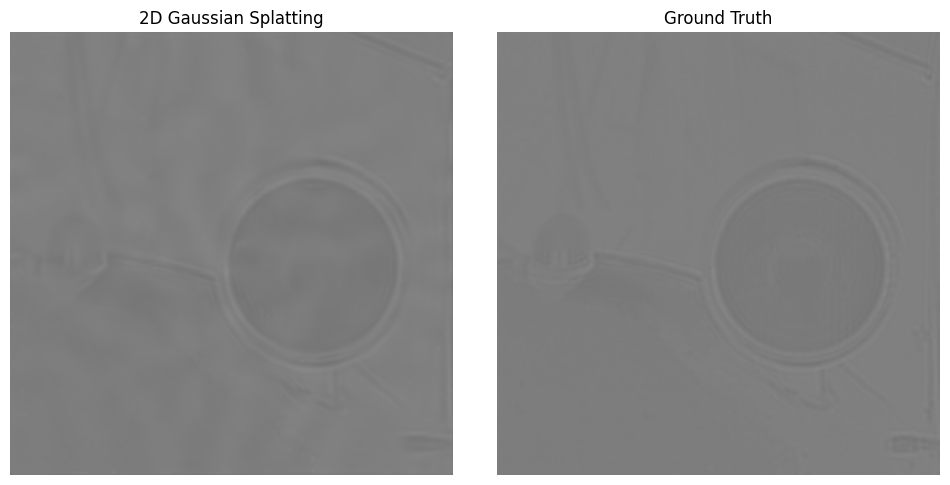

Epoch 1501/20001, Loss: 0.0041379621252417564, on 2702 points


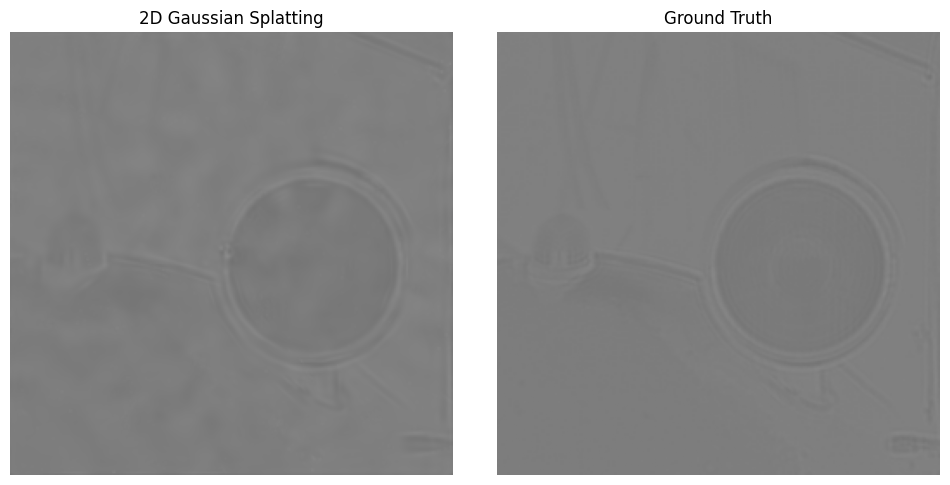

Epoch 1601/20001, Loss: 0.004446790087968111, on 3305 points


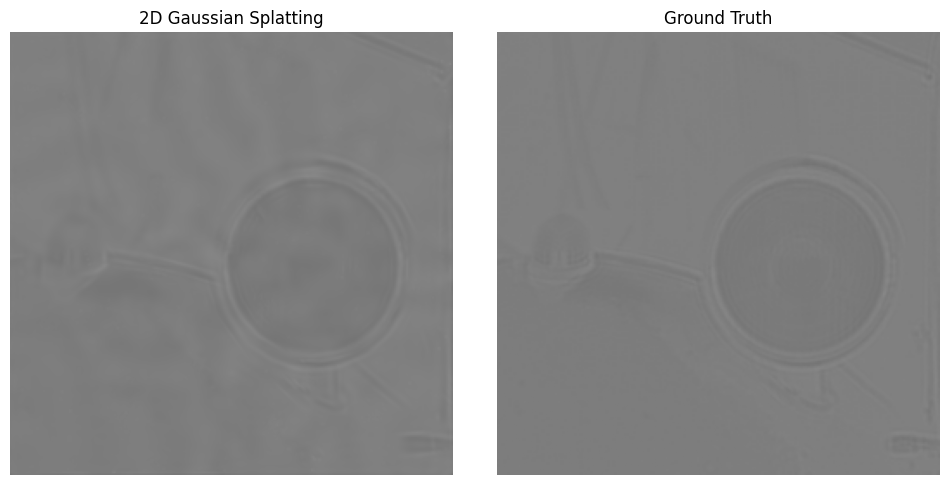

Epoch 1701/20001, Loss: 0.0042958939447999, on 3305 points
Number of splitted points: 319
Number of cloned points: 279


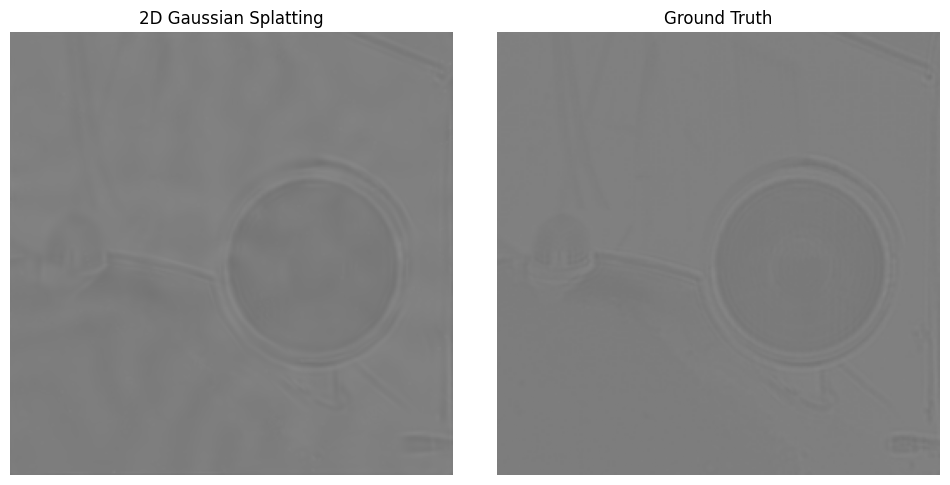

Epoch 1801/20001, Loss: 0.003998338710516691, on 3305 points


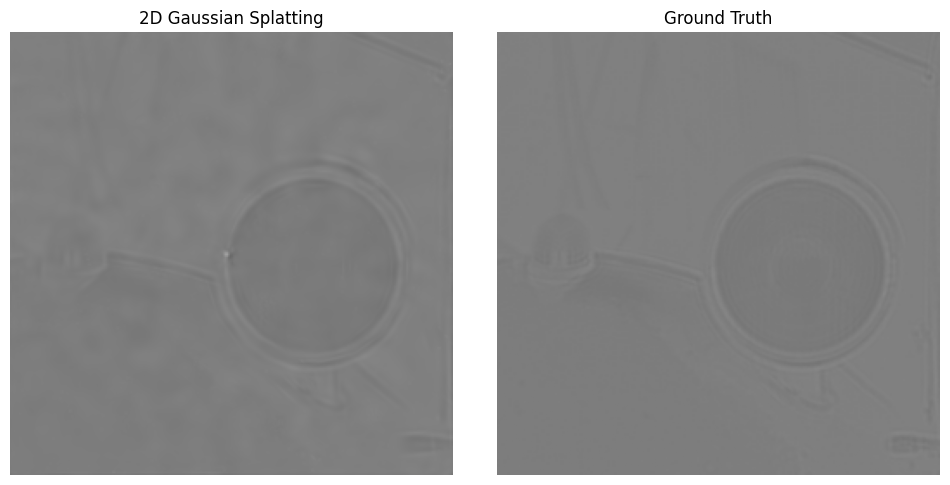

Epoch 1901/20001, Loss: 0.004053829237818718, on 3903 points


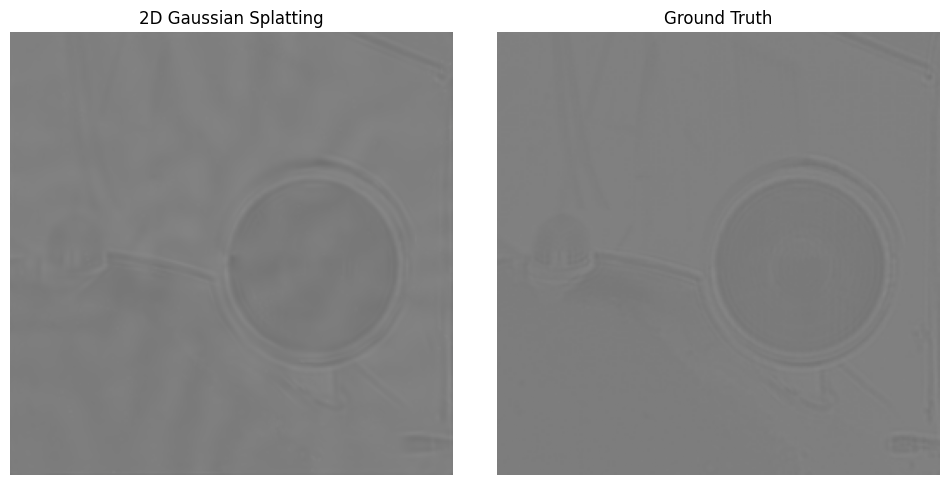

Epoch 2001/20001, Loss: 0.004322146996855736, on 3903 points
Number of splitted points: 283
Number of cloned points: 294


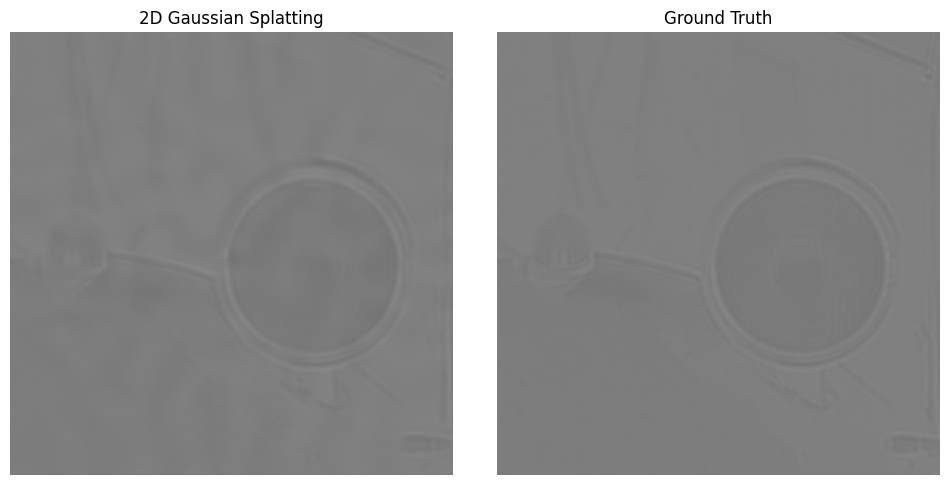

Epoch 2101/20001, Loss: 0.003916013054549694, on 3903 points


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.28 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.86 GiB is free. Process 5429 has 12.88 GiB memory in use. Of the allocated memory 12.73 GiB is allocated by PyTorch, and 10.14 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for epoch in range(num_epochs):

    #find indices to remove and update the persistent mask
    if epoch % (densification_interval + 1) == 0 and epoch > 0:
        indices_to_remove = (torch.sigmoid(W[:, 3]) < 0.01).nonzero(as_tuple=True)[0]

        if len(indices_to_remove) > 0:
          print(f"number of pruned points: {len(indices_to_remove)}")

        persistent_mask[indices_to_remove] = False

        # Zero-out parameters and their gradients at every epoch using the persistent mask
        W.data[~persistent_mask] = 0.0


    gc.collect()
    torch.cuda.empty_cache()

    output = W[persistent_mask]

    batch_size = output.shape[0]

    scale = torch.sigmoid(output[:, 0:2])
    rotation = np.pi / 2 * torch.tanh(output[:, 2])
    alpha = torch.sigmoid(output[:, 3])
    colours = torch.sigmoid(output[:, 4:7])
    pixel_coords = torch.tanh(output[:, 7:9])

    colours_with_alpha  = colours * alpha.view(batch_size, 1)
    g_tensor_batch = generate_2D_gaussian_splatting(KERNEL_SIZE, scale, rotation, pixel_coords, colours, image_size, device=device)
    loss = combined_loss(g_tensor_batch, target_tensor, lambda_param=0.2)

    optimizer.zero_grad()

    loss.backward()

    # Apply zeroing out of gradients at every epoch
    if persistent_mask is not None:
        W.grad.data[~persistent_mask] = 0.0

    if epoch % densification_interval == 0 and epoch > 0:

      # Calculate the norm of gradients
      gradient_norms = torch.norm(W.grad[persistent_mask][:, 7:9], dim=1, p=2)
      gaussian_norms = torch.norm(torch.sigmoid(W.data[persistent_mask][:, 0:2]), dim=1, p=2)

      sorted_grads, sorted_grads_indices = torch.sort(gradient_norms, descending=True)
      sorted_gauss, sorted_gauss_indices = torch.sort(gaussian_norms, descending=True)

      large_gradient_mask = (sorted_grads > grad_threshold)
      large_gradient_indices = sorted_grads_indices[large_gradient_mask]

      large_gauss_mask = (sorted_gauss > gauss_threshold)
      large_gauss_indices = sorted_gauss_indices[large_gauss_mask]

      common_indices_mask = torch.isin(large_gradient_indices, large_gauss_indices)
      common_indices = large_gradient_indices[common_indices_mask]
      distinct_indices = large_gradient_indices[~common_indices_mask]

      # Split points with large coordinate gradient and large gaussian values and descale their gaussian
      if len(common_indices) > 0:
        print(f"Number of splitted points: {len(common_indices)}")
        start_index = current_marker + 1
        end_index = current_marker + 1 + len(common_indices)
        persistent_mask[start_index: end_index] = True
        W.data[start_index:end_index, :] = W.data[common_indices, :]
        scale_reduction_factor = 1.6
        W.data[start_index:end_index, 0:2] /= scale_reduction_factor
        W.data[common_indices, 0:2] /= scale_reduction_factor
        current_marker = current_marker + len(common_indices)

      # Clone it points with large coordinate gradient and small gaussian values
      if len(distinct_indices) > 0:

        print(f"Number of cloned points: {len(distinct_indices)}")
        start_index = current_marker + 1
        end_index = current_marker + 1 + len(distinct_indices)
        persistent_mask[start_index: end_index] = True
        W.data[start_index:end_index, :] = W.data[distinct_indices, :]

        # Calculate the movement direction based on the positional gradient
        positional_gradients = W.grad[distinct_indices, 7:9]
        gradient_magnitudes = torch.norm(positional_gradients, dim=1, keepdim=True)
        normalized_gradients = positional_gradients / (gradient_magnitudes + 1e-8)  # Avoid division by zero

        # Define a step size for the movement
        step_size = 0.01

        # Move the cloned Gaussians
        W.data[start_index:end_index, 7:9] += step_size * normalized_gradients

        current_marker = current_marker + len(distinct_indices)

    optimizer.step()

    loss_history.append(loss.item())

    if epoch % display_interval == 0:
        num_subplots = 3 if display_loss else 2
        fig_size_width = 18 if display_loss else 12

        fig, ax = plt.subplots(1, num_subplots, figsize=(fig_size_width, 6))  # Adjust subplot to 1x3

        generated_array = g_tensor_batch.cpu().detach().numpy()

        ax[0].imshow(g_tensor_batch.cpu().detach().numpy())
        ax[0].set_title('2D Gaussian Splatting')
        ax[0].axis('off')

        ax[1].imshow(target_tensor.cpu().detach().numpy())
        ax[1].set_title('Ground Truth')
        ax[1].axis('off')

        if display_loss:
          ax[2].plot(range(epoch + 1), loss_history[:epoch + 1])
          ax[2].set_title('Loss vs. Epochs')
          ax[2].set_xlabel('Epoch')
          ax[2].set_ylabel('Loss')
          ax[2].set_xlim(0, num_epochs)  # Set x-axis limits

        # Display the image
        #plt.show(block=False)
        plt.subplots_adjust(wspace=0.1)  # Adjust this value to your preference
        plt.pause(0.1)  # Brief pause

        img = Image.fromarray((generated_array * 255).astype(np.uint8))

        # Create filename
        filename = f"{epoch}.jpg"

        # Construct the full file path
        file_path = os.path.join(directory, filename)

        # Save the image
        img.save(file_path)

        fig.savefig(file_path, bbox_inches='tight')

        plt.clf()  # Clear the current figure
        plt.close()  # Close the current figure

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, on {len(output)} points")




In [ ]:
 image_files = []
for i in range(0, num_epochs, display_interval):
  image_files.append(f"{i}.jpg")

# Create a video writer object
writer = imageio.get_writer(os.path.join(directory, 'video.mp4'), fps=2)

# Add images to the video writer
for image_file in image_files:
    image_path = os.path.join(directory, image_file)
    image = imageio.imread(image_path)
    writer.append_data(image)

writer.close()

<ipython-input-27-0e491a4fe081>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


FileNotFoundError: No such file: '/content/2025_02_26-10_02_04/2200.jpg'